In [1]:
import os
import csv
import pandas as pd

from tqdm import tqdm
from collections import Counter

In [2]:
file_list = os.listdir('./Keystrokes/files/')
file_list.remove('readme.txt')
file_list.remove('metadata_participants.txt')
len(file_list)

168593

In [4]:
# preproc files
for file in tqdm(file_list):

    f = open('./Keystrokes/files/' + file, 'r', encoding='windows-1252')

    # read file
    content = f.read()
    f.close()

    # replace \n
    content = content.replace('\t\n\t', '\tnewline\t')
    content = content.replace('\t\t\t', '\ttab\t')

    # save file
    f = open('./Keystroke_prc/' + file, 'w', encoding='windows-1252')
    f.write(content)
    f.close()


100%|██████████| 168593/168593 [03:16<00:00, 856.36it/s]


In [5]:
def keystrokes_to_session(key_df: pd.DataFrame) -> pd.DataFrame:
    """
    Transform a keystroke dataframe into session dataframe.
    """
    grp_df = key_df.groupby(['PARTICIPANT_ID', 'TEST_SECTION_ID'])

    # iterate over each group
    press_code = 1
    release_code = 0

    session_data = []
    
    for name, seq_group in grp_df:
        # iterate through seq_group
        sequence = []
        
        for index, row in seq_group.iterrows():
            press_time = row['PRESS_TIME']
            release_time = row['RELEASE_TIME']
            keycode = row['KEYCODE']
            sequence.append([press_time, press_code, keycode])
            sequence.append([release_time, release_code, keycode])

        # sort sequence by timea
        sequence.sort(key=lambda x: x[0])

        # append to session_data
        session_data.append([name[0], name[1], sequence])


    sessions_df = pd.DataFrame(session_data, columns=['PARTICIPANT_ID', 'TEST_SECTION_ID', 'SEQUENCE'])

    return sessions_df


In [7]:
from collections import defaultdict
from Levenshtein import distance

failed_files = []
failed_due_to_nan = []

# test_section_id: test_section_text
test_section_dict = defaultdict(str)
unique_count = Counter()


dist_data = []

for file in tqdm(file_list):
    try: 
        df = pd.read_csv('./Keystroke_prc/' + file , sep='\t', encoding="windows-1252", quoting=csv.QUOTE_NONE)

        gr_df = df.groupby(['PARTICIPANT_ID', 'TEST_SECTION_ID', 'SENTENCE', 'USER_INPUT'])
        
        for name, seq_group in gr_df:
            

            sentence = name[2]
            user_input = name[3]

            # compute levenstein distance between sentence and user_input
            dist = distance(sentence, user_input)
            dist_data.append([name[0], name[1], dist])

        # # transform to session
        # sessions_df = keystrokes_to_session(df)
        # sessions_df.to_csv('./Keystroke_sessions/' + file, index=False)
        
        if df['KEYCODE'].isnull().values.any():
            failed_due_to_nan.append((file, df['KEYCODE'].isnull().sum(), len(df)))
            continue
    except:
        failed_files.append(file)

# print("Failed due to nan",  len(failed_due_to_nan))
# print("Failed due to other", len(failed_files))

100%|██████████| 168593/168593 [06:20<00:00, 442.78it/s]


Text(0, 0.5, 'Număr de exemple')

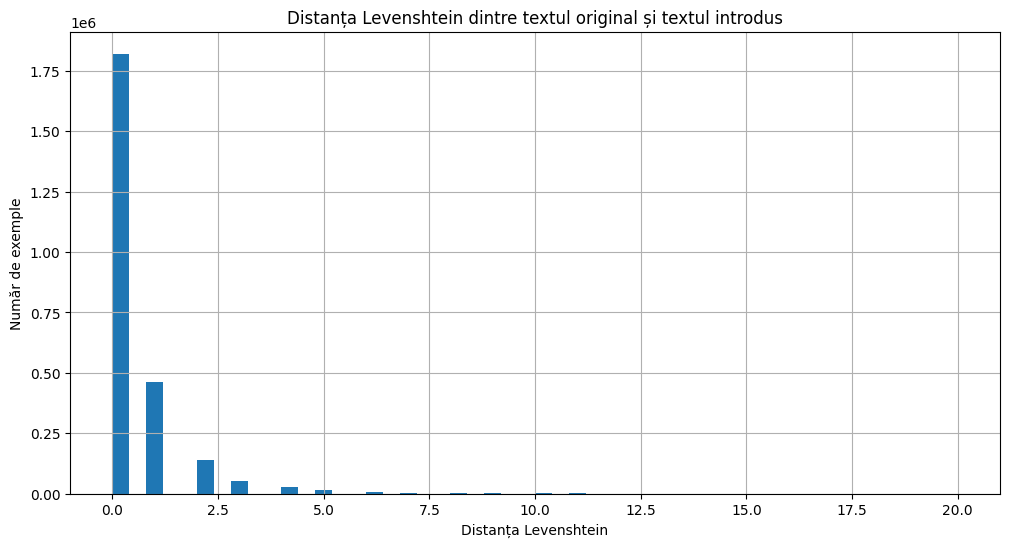

In [17]:
# histplot of levenstein distance
dist_df = pd.DataFrame(dist_data, columns=['PARTICIPANT_ID', 'TEST_SECTION_ID', 'DISTANCE'])


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
# plt.yscale('log')
dist_df['DISTANCE'].hist(bins=50)
plt.title('Levenstein distance between sentence and user input')
plt.xlabel('Levenstein distance')
plt.ylabel('Count')


In [ ]:
dist_df = pd.DataFrame(dist_data, columns=['PARTICIPANT_ID', 'TEST_SECTION_ID', 'DISTANCE'])
dist_df.head()

In [ ]:
# sessions per participant

In [8]:
# # dataframe with test_section_id and test_section_text
# test_section_df = pd.DataFrame.from_dict(test_section_dict, orient='index', columns=['SENTENCE'])[:100]
# test_section_df.to_excel('./Keystroke_test_section.xlsx', index=True)

In [3]:
# per session stats

sess_per_subj = []
events_per_sess = []
delt_time = []
max_time_diff = []


for file in tqdm(file_list):

    df = pd.read_csv('./Keystroke_sessions/' + file)

    # sess_per_subj.append(len(df))
    events_per_sess.extend(df['SEQUENCE'].apply(lambda x: len(eval(x))/2).tolist())
    # delt_time.extend(df['SEQUENCE'].apply(lambda x: eval(x)[-1][0] - eval(x)[0][0]).tolist())
    # time_list = df['SEQUENCE'].apply(lambda x : eval(x)).tolist()

    # time_list = df['SEQUENCE'].apply(lambda x : eval(x)).tolist()

    # for time_seq in time_list:
    #     time_diff = [time_seq[i][0] - time_seq[i-1][0] for i in range(1, len(time_seq))]
    #     max_time_diff.append(max(time_diff))



100%|██████████| 168593/168593 [16:22<00:00, 171.54it/s]  


Text(0, 0.5, 'Frecventa')

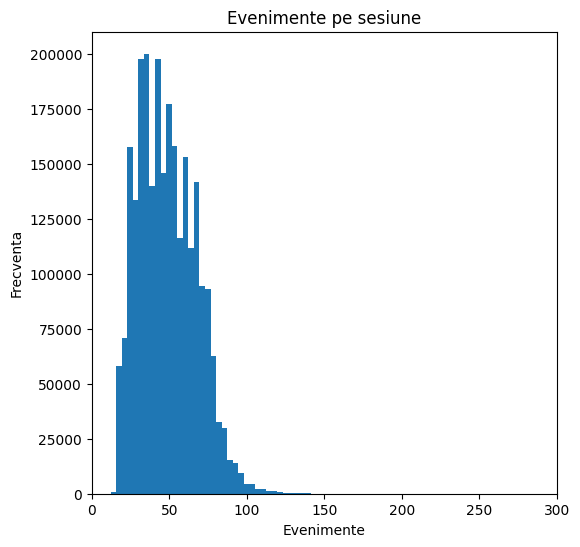

In [11]:
import matplotlib.pyplot as plt
# histplot events per session
plt.figure(figsize=(6, 6))
# plt.yscale('log')
plt.hist(events_per_sess, bins=200)
plt.title('Evenimente pe sesiune')
plt.xlabel('Evenimente')
plt.xlim(0, 300)
plt.ylabel('Frecventa')


Text(0, 0.5, 'Număr de exemple')

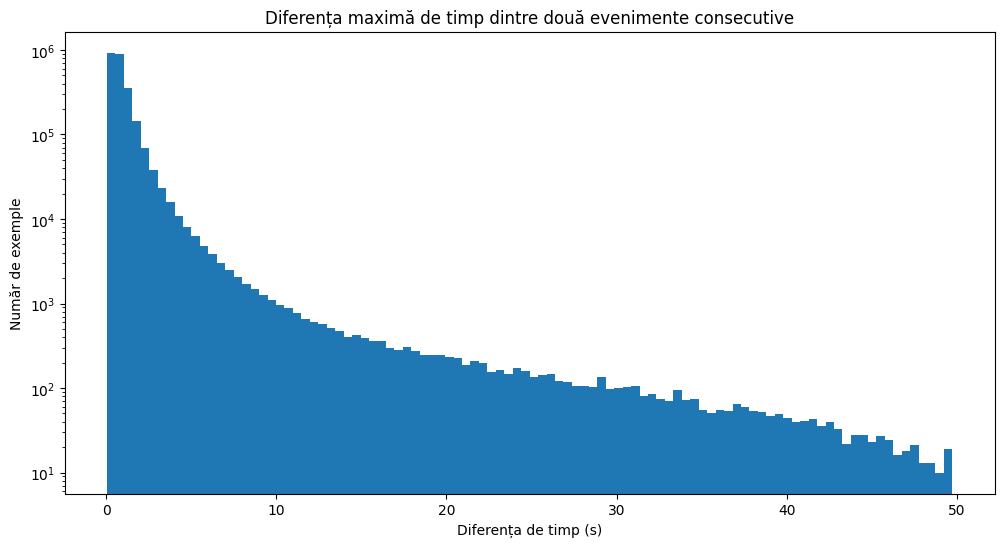

In [52]:
# from ms to s
max_time_diff_prc = [ x/1000 for x in max_time_diff]
plt.figure(figsize=(12, 6))
plt.yscale('log')
plt.hist(max_time_diff_prc, bins=100)
plt.title('Max time difference between two consecutive events')
plt.xlabel('Time difference (s)')
plt.ylabel('Count')


Text(0, 0.5, 'Număr de exemple')

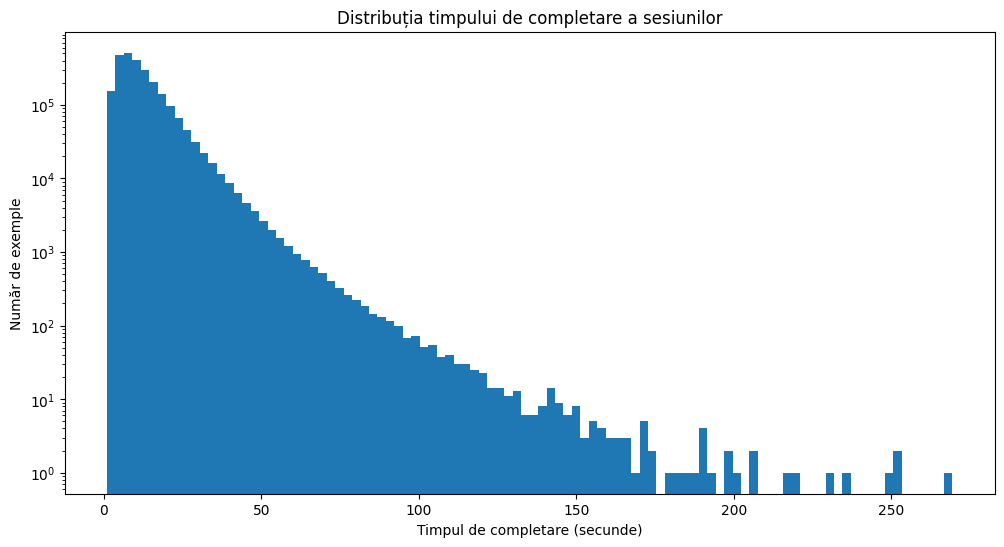

In [41]:
#histplot of delta time
plt.figure(figsize=(12, 6))

delt_time_sec = [x/1000 for x in delt_time]
plt.yscale('log')
plt.hist(delt_time_sec, bins=100)
plt.title('Delta time between first and last event')
plt.xlabel('Delta time (s)')
plt.ylabel('Count')

In [ ]:
# Set the limits for the Levenshtein distance and the delta time

max_delta_time_lim = 5
max_lev_dist_lim = 5

In [33]:
#mean
print("Mean sessions per participant", sum(sess_per_subj)/len(sess_per_subj))
print("Mean events per session", sum(events_per_sess)/len(events_per_sess))

Mean sessions per participant 15.0
Mean events per session 48.68055494593489


In [34]:
len(file_list) * 15

2528895